<a href="https://colab.research.google.com/github/alexyev/pennylane_projects/blob/master/Quantum_Gradients_w_Backpropagation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pennylane
import pennylane as qml
from pennylane import numpy as np
from matplotlib import pyplot as plt

     |████████████████████████████████| 756 kB 5.1 MB/s 
     |████████████████████████████████| 305 kB 20.1 MB/s 
     |████████████████████████████████| 108 kB 6.4 MB/s 


In [2]:
np.random.seed(42)

dev = qml.device('default.qubit', wires=3)

@qml.qnode(dev, diff_method='parameter-shift')
def circuit(params):
  qml.RX(params[0], wires=0)
  qml.RY(params[1], wires=1)
  qml.RZ(params[2], wires=2)

  qml.broadcast(qml.CNOT, wires=[0, 1, 2], pattern='ring')

  qml.RX(params[3], wires=0)
  qml.RY(params[4], wires=1)
  qml.RZ(params[5], wires=2)

  qml.broadcast(qml.CNOT, wires=[0, 1, 2], pattern='ring')
  return qml.expval(qml.PauliY(0) @ qml.PauliZ(2))


In [3]:
params = np.random.random([6], requires_grad=True)
print('Parameters:', params)
print('Expectation Value: ', circuit(params))

Parameters: [0.37454012 0.95071431 0.73199394 0.59865848 0.15601864 0.15599452]
Expectation Value:  -0.11971365706871569


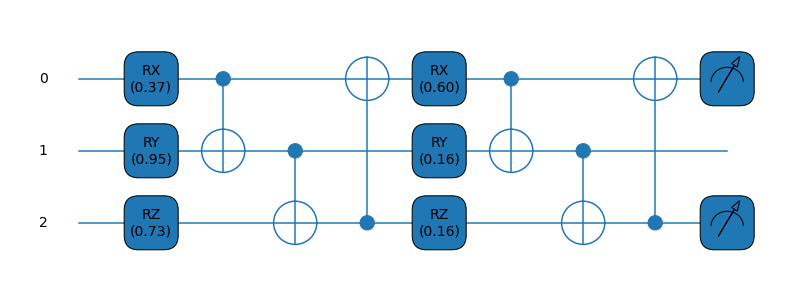

In [4]:
fig, ax = qml.draw_mpl(circuit, decimals=2)(params)
plt.show()

In [5]:
def parameter_shift_term(qnode, params, i):
  shifted = params.copy()
  shifted[i] += np.pi/2
  forward = qnode(shifted)

  shifted[i] -= np.pi
  backward = qnode(shifted)

  return 0.5 * (forward - backward)

print(parameter_shift_term(circuit, params, 0))

-0.0651887722495813


In [6]:
def parameter_shift(qnode, params):
  gradients = np.zeros([len(params)])

  for i in range(len(params)):
    gradients[i] = parameter_shift_term(qnode, params, i)

  return gradients

print(parameter_shift(circuit, params))


[-6.51887722e-02 -2.72891905e-02  0.00000000e+00 -9.33934621e-02
 -7.61067572e-01  8.32667268e-17]


In [7]:
grad_function = qml.grad(circuit)
print(grad_function(params)[0])

-0.0651887722495813


In [8]:
print(qml.gradients.param_shift(circuit)(params))

[[-6.51887722e-02 -2.72891905e-02  0.00000000e+00 -9.33934621e-02
  -7.61067572e-01  8.32667268e-17]]


In [9]:
dev = qml.device('default.qubit', wires=4)

@qml.qnode(dev, diff_method='parameter-shift')
def circuit(params):
  qml.StronglyEntanglingLayers(params, wires=[0, 1, 2, 3])
  return qml.expval(qml.PauliZ(0) @ qml.PauliZ(1) @ qml.PauliZ(2) @ qml.PauliZ(3))

In [10]:
param_shape = qml.StronglyEntanglingLayers.shape(n_wires=4, n_layers=15)
params = np.random.normal(scale=0.1, size=param_shape, requires_grad=True)
print(params.size)
print(circuit(params))

180
0.8947771876917632


In [11]:
import timeit

reps = 3
num = 10
times = timeit.repeat('circuit(params)', globals=globals(), number=num, repeat=reps)
forward_time = min(times) / num

print(f"Forward pass (best out of {reps}): {forward_time} sec per loop")

Forward pass (best out of 3): 0.026181478799998104 sec per loop


In [12]:
grad_fn = qml.grad(circuit)

times = timeit.repeat('grad_fn(params)', globals=globals(), number=num, repeat=reps)
backward_time = min(times) / num

print(f'Gradient computation (best of {reps}: {backward_time} sec per loop)')

Gradient computation (best of 3: 10.052072224799996 sec per loop)


In [13]:
print(2 * forward_time * params.size)

9.425332367999317


In [14]:
# now the fun with backprop begins

dev = qml.device('default.qubit', wires=4)
@qml.qnode(dev, diff_method='backprop')
def circuit(params):
  qml.StronglyEntanglingLayers(params, wires=[0, 1, 2, 3])
  return qml.expval(qml.PauliZ(0) @ qml.PauliZ(1) @ qml.PauliZ(2) @qml.PauliZ(3))

param_shape = qml.StronglyEntanglingLayers.shape(n_wires=4, n_layers=15)
params = np.random.normal(scale=0.1, size=param_shape, requires_grad=True)
print(circuit(params))

0.9358535378025427


In [15]:
reps = 3
num = 10
times = timeit.repeat('circuit(params)', globals=globals(), number=num, repeat=reps)
forward_time = min(times) / num
print(f'Forward pass (best of {reps}): {forward_time} sec per loop')

Forward pass (best of 3): 0.07281304959999488 sec per loop


In [16]:
times = timeit.repeat('qml.grad(circuit(params))', globals=globals(), number=num, repeat=reps)
backward_time = min(times)/num
print(f'Backward time (best of {reps}): {backward_time} sec per loop')

Backward time (best of 3): 0.07131233459999749 sec per loop


In [21]:
# time comparison between parameter-shift and backprop as number of layers increases

dev = qml.device('default.qubit', wires=4)

def circuit(params):
  qml.StronglyEntanglingLayers(params, wires=[0, 1, 2, 3])
  return qml.expval(qml.PauliZ(0) @ qml.PauliZ(1) @ qml.PauliZ(2) @ qml.PauliZ(3))

In [39]:
reps = 2 
num = 3

forward_shift_init = []
gradient_shift_init = []
forward_backprop_init = []
gradient_backprop_init = []

for depth in range(0, 21):
  param_shape = qml.StronglyEntanglingLayers.shape(n_wires=4, n_layers=depth)
  params = np.random.normal(scale=0.1, size=param_shape, requires_grad=True)
  num_params = params.size

# time the forward pass

  qnode_shift = qml.QNode(circuit, dev, diff_method = 'parameter-shift')
  qnode_backprop = qml.QNode(circuit, dev, diff_method = 'backprop')

  # time the parameter shift

  t = timeit.repeat('qnode_shift(params)', globals=globals(), number=num, repeat=reps)
  forward_shift_init.append([num_params, min(t)/ num])

  # backprop

  t = timeit.repeat('qnode_backprop(params)', globals=globals(), number=num, repeat=reps)
  forward_backprop_init.append([num_params, min(t) / num])

  if num_params == 0:
    continue

  # gradient timing

  qnode_shift = qml.QNode(circuit, dev, diff_method='parameter-shift')
  qnode_backprop = qml.QNode(circuit, dev, diff_method='backprop')

  # parameter shift

  t = timeit.repeat('qml.grad(qnode_shift)(params)', globals=globals(), number=num, repeat=reps)
  gradient_shift_init.append([num_params, min(t) / num])

  # backprop

  t = timeit.repeat('qml.grad(qnode_backprop)(params)', globals=globals(), number=num, repeat=reps)
  gradient_backprop_init.append([num_params, min(t) / num])



In [40]:
  gradient_shift_init = np.array(gradient_shift_init).T
  gradient_backprop_init = np.array(gradient_backprop_init).T
  forward_shift_init = np.array(forward_shift_init).T
  forward_backprop_init = np.array(forward_backprop_init).T

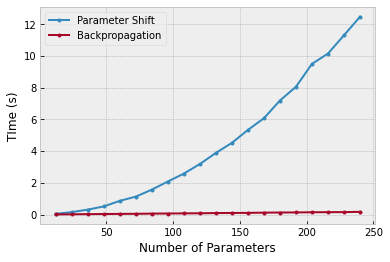

In [41]:
plt.style.use('bmh')

fig, ax = plt.subplots(1,1, figsize=(6, 4))

ax.plot(*gradient_shift_init, '.-', label='Parameter Shift')
ax.plot(*gradient_backprop_init, '.-', label='Backpropagation')
ax.set_ylabel('TIme (s)')
ax.set_xlabel('Number of Parameters')
ax.legend()

plt.show()